In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import skimage
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

np.random.seed(42)

In [2]:
dataset_path = './asl_dataset'
class_names = [
  '0','1','2','3','4','5','6',
  '7','8','9','a','b','c','d',
  'e','f','g','h','i','j','k',
  'l','m','n','o','p','q','r',
  's','t','u','v','w','x','y',
  'z'
]
# Loading and preprocessing Image Data https://www.section.io/engineering-education/image-preprocessing-in-python/#:~:text=In%20this%20tutorial%2C%20we%20shall,used%20to%20preprocess%20image%20data.
dataPaths = []
for i in range(len(class_names)):
  path = os.path.join(dataset_path, class_names[i], '*')
  path = glob.glob(path)
  dataPaths.append(path)


# Merging Dataframes: https://www.stackvidhya.com/add-row-to-dataframe/
df = pd.DataFrame()
for i in range(len(dataPaths)):
  current_df = pd.DataFrame({"path": dataPaths[i], "category": class_names[i]})
  df = pd.concat([df, current_df], ignore_index=True, axis=0)
df.to_csv(f'./temp/categorized.csv')


40


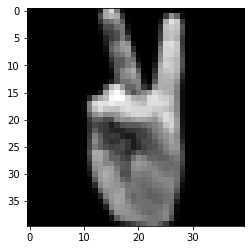

In [25]:
# gray_image = skimage.color.rgb2gray(io.imread(df['path'][200]))
# Starting with downscaled image
gray_image = rescale(skimage.color.rgb2gray(io.imread(df['path'][200])), 0.1)
plt.imshow(gray_image, cmap = 'gray')
pixels = gray_image.shape[0] * gray_image.shape[1]


In [7]:
column_names = []
[column_names.append("p"+str(x)) for x in range(0,pixels)] # shape (785,0)
column_names.append("category")
numberized_df = pd.DataFrame(columns=column_names)
for i in range(len(class_names)):
  print(class_names[i])
  for j in range(len(dataPaths[i])):
    image = io.imread(dataPaths[i][j])
    gray_image = rescale(skimage.color.rgb2gray(image), 0.1)
    numberized_image = gray_image.flatten()
    numberized_image = np.append(numberized_image, i)
    numberized_image_df = pd.DataFrame(columns=column_names)
    numberized_image_df.loc[0] = numberized_image
    numberized_df = pd.concat([numberized_df,numberized_image_df], ignore_index=True)

0
1
2
3
4
5
6
7
8
9
a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z


In [17]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(numberized_df, numberized_df['category']):
    train_set = numberized_df.loc[train_index]
    test_set = numberized_df.loc[test_index]

train_data = train_set.drop("category", axis=1) 
train_labels = train_set["category"].copy().to_numpy().astype('int')
print(train_data.shape)

test_data = test_set.drop("category", axis=1) 
test_labels = test_set["category"].copy().to_numpy().astype('int')
print(test_data.shape)

(2263, 1600)
(252, 1600)


In [18]:
# I THINK IT IS ALSREADY SCALED BETWEEN ! AND ) BUT JUST TO BE SAFE !!

# REVISIT LATER

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data.values)

scaled_df = pd.DataFrame(train_scaled, index=train_set.index, columns=train_data.columns)

print(np.max(scaled_df.p1.to_numpy()))
print(np.min(scaled_df.p1.to_numpy()))

1.0
0.0


In [19]:
model = SVC(random_state=42, probability=True)

# specify the parameter combinations to be tested
parameters = [
    {'C': [10, 100], 'gamma': [0.001, 0.0001], 'kernel': ['linear', 'rbf']}
]
grid_search = GridSearchCV(model, parameters)#, cv=10, return_train_score=True, n_jobs=-1)
grid_search.fit(train_scaled, train_labels)



GridSearchCV(estimator=SVC(probability=True, random_state=42),
             param_grid=[{'C': [10, 100], 'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'rbf']}])

In [60]:

# specify the parameter combinations to be tested

clf = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
clf.fit(train_scaled, train_labels)

MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=300, random_state=1)

In [72]:
test_scaled = scaler.transform(test_data.values)
test_predictions = grid_search.best_estimator_.predict(test_data.values)
cls_report_test = classification_report(test_labels, test_predictions)
print(cls_report_test)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       1.00      1.00      1.00         7
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       1.00      0.71      0.83         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         7
          13       1.00      1.00      1.00         7
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.00         7
          16       1.00      1.00      1.00         7
          17       1.00    

# User Testing
After training the model, I decided to use an actual picture of my own to see if I can get the right output

<ipython-input-69-d56fe312a531>:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  gray_image = resize(skimage.color.rgb2gray(io.imread('./Untitled.png')), (40,40))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


a
a


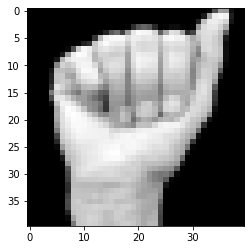

In [69]:

tmp = io.imread('./Untitled.png')

gray_image = resize(skimage.color.rgb2gray(io.imread('./Untitled.png')), (40,40))
numberized_image = gray_image.flatten()

column_names = []
[column_names.append("p"+str(x)) for x in range(0,len(numberized_image))] # shape (785,0)
numberized_df = pd.DataFrame(columns=column_names)

numberized_df = pd.DataFrame(columns=column_names)
numberized_image_df = pd.DataFrame(columns=column_names)
numberized_image_df.loc[0] = numberized_image

plt.imshow(gray_image, cmap = 'gray')

predictions = grid_search.predict_proba(numberized_image_df)[0]

print(class_names[predictions.argmax(axis=0)])

MLP_predictions = clf.predict_proba(numberized_image_df)[0]

print(class_names[MLP_predictions.argmax(axis=0)])
